This notebook is responsible for exporting the MLPF trained model from pytorch to ONNX.

In [1]:
# !pip install onnxscript
# !pip install onnxconverter-common

In [2]:
import matplotlib
import copy
import pickle as pkl
import sys
import numpy as np
from tqdm import tqdm
import tensorflow_datasets as tfds
import math

import numba
import awkward
import vector
import fastjet
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep

import boost_histogram as bh
import mplhep

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from torch import Tensor

import onnxscript
import onnx
import onnxruntime as rt
from onnxconverter_common import float16
from onnxscript.function_libs.torch_lib.tensor_typing import TFloat

sys.path.append("../../")
import mlpf
from mlpf.model.mlpf import MLPF
from mlpf.model.utils import unpack_predictions, unpack_target
from mlpf.jet_utils import match_jets, to_p4_sph
from mlpf.plotting.plot_utils import cms_label, sample_label

In [3]:
mplhep.style.use("CMS")

In [4]:
#check which onnxruntime we are using. For CUDA, we must use onnxruntime-gpu (not onnxruntime)
rt.__path__, rt.__version__

(['/opt/conda/lib/python3.11/site-packages/onnxruntime'], '1.20.1')

In [5]:
torch.__version__

'2.5.1+cu124'

In [6]:
# contrib op: https://github.com/microsoft/onnxruntime/blob/main/docs/ContribOperators.md#commicrosoftmultiheadattention
# CMSSW ONNXRuntime version: https://github.com/cms-sw/cmsdist/blob/REL/CMSSW_14_1_0_pre3/el9_amd64_gcc12/onnxruntime.spec
# ONNXRuntime compatiblity table: https://onnxruntime.ai/docs/reference/compatibility.html

#with pytorch 2.5.0, we should use at least opset 20 (previous opsets did not work)
from onnxscript import opset20 as op
opset_version = 20

custom_opset = onnxscript.values.Opset(domain="onnx-script", version=1)
msft_op = onnxscript.values.Opset("com.microsoft", 1)

In [7]:
!ls /home/joosep/particleflow/experiments/pyg-cms_20250510_121014_108409/checkpoints/

ls: cannot access '/home/joosep/particleflow/experiments/pyg-cms_20250510_121014_108409/checkpoints/': No such file or directory


In [8]:
#tfds datasets are here:
data_dir = "/scratch/persistent/joosep/tensorflow_datasets/"
dataset = "cms_pf_ttbar"

#model checkpoints are here:
outdir = "/home/joosep/particleflow/experiments/pyg-cms_20250517_232752_544969"

#Load model weights from existing training
model_state = torch.load(
    outdir + "/checkpoints/checkpoint-08-3.863894.pth", map_location=torch.device("cpu")
)
with open(f"{outdir}/model_kwargs.pkl", "rb") as f:
    model_kwargs = pkl.load(f)

#this is needed to configure com.microsoft.MultiHeadAttention
NUM_HEADS = model_kwargs["num_heads"]

#set this to cuda if you are running the notebook on a GPU, otherwise use cpu
torch_device = torch.device("cpu")

/tmp/ipykernel_1727996/3550332433.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(


In [9]:
#Load the base model from our codebase, initialize with trained weights
model = MLPF(**model_kwargs)
model.eval()

model.load_state_dict(model_state["model_state_dict"], strict=False)

model = model.to(device=torch_device)

for conv in model.conv_id + model.conv_reg:
    conv.outdir = "."
    conv.save_attention = True
    conv.export_onnx = True
    conv.enable_ctx_manager = True

In [83]:
def Causal_Mask_Decay(a_i , L):
    idx = torch.arange(L,device=a_i.device)
    I, J = torch.meshgrid(idx, idx, indexing='ij')
    E = (torch.abs((I-J)).float().view(1,1,L,L))
    M = torch.sigmoid(a_i).view(1,-1,1,1)**E
    return M

def Casual_Mask_Decay_Partial(a_i , L, start, end):
    idx = torch.arange(L,device=a_i.device)
    I, J = torch.meshgrid(idx, idx[start:end], indexing='ij')
    E = (torch.abs((I-J)).float().view(1,1,L,len(idx[start:end])))
    M = torch.sigmoid(a_i).view(1,-1,1,1)**E
    return M

def create_matrix_from_tensor(tensor):
    cumsum = torch.cumsum(tensor, dim=-1)
    prepend_zeros = torch.zeros(*tensor.shape[:-1], 1, dtype=tensor.dtype, device=tensor.device)
    cumsum = torch.cat((prepend_zeros, cumsum), dim=-1)
    A = cumsum[..., 1:].unsqueeze(-2) - cumsum[..., :-1].unsqueeze(-1)
    A = torch.tril(A.transpose(-1, -2))
    zero_row = torch.zeros(*A.shape[:-2], 1, A.shape[-1], dtype=A.dtype, device=A.device)
    A = torch.cat((zero_row, A[..., :-1, :]), dim=-2)
    return torch.tril(torch.exp(A))

def Causal_Mask_Selective(vec):
    vec_shape = vec.shape
    A_for = create_matrix_from_tensor(vec.unsqueeze(-1).transpose(-1,-2)).squeeze()
    A_back = create_matrix_from_tensor(torch.cat((vec,torch.ones((vec_shape[0],vec_shape[1],1),device=vec.device)),dim=-1)[:,:,1:].unsqueeze(-1).transpose(-1,-2)).transpose(-1,-2).squeeze()    
    return A_for + A_back - torch.eye(A_for.shape[-1]).to(A_for.device)

def create_matrix_from_tensor_forward(tensor, chunk_index,chunk_len):
    cumsum = torch.cumsum(tensor, dim=-1)
    prepend_zeros = torch.zeros(*tensor.shape[:-1], 1, dtype=tensor.dtype, device=tensor.device)
    cumsum = torch.cat((prepend_zeros, cumsum), dim=-1)
    A = cumsum[..., 1:].unsqueeze(-2) - cumsum[..., :-1].unsqueeze(-1)[...,chunk_index*chunk_len:(chunk_index+1)*chunk_len,:]
    A = A.transpose(-1, -2)
    zero_row = torch.zeros(*A.shape[:-2], 1, A.shape[-1], dtype=A.dtype, device=A.device)
    A = torch.cat((zero_row, A[..., :-1, :]), dim=-2)
    return torch.tril(torch.exp(A), diagonal = -chunk_index*chunk_len)

def create_matrix_from_tensor_backward(tensor,chunk_index,chunk_len):
    cumsum = torch.cumsum(tensor, dim=-1)
    prepend_zeros = torch.zeros(*tensor.shape[:-1], 1, dtype=tensor.dtype, device=tensor.device)
    cumsum = torch.cat((prepend_zeros, cumsum), dim=-1)
    A = cumsum[..., :-2].unsqueeze(-2)[...,chunk_index*chunk_len:(chunk_index+1)*chunk_len]  - cumsum[..., :-2].unsqueeze(-1)
    A = A.transpose(-1, -2)
    return torch.tril(torch.exp(A), diagonal = chunk_index*chunk_len)    
   
def Casual_Mask_Selective_Partial(vec, chunk_index, chunk_len):
    B,H,L = vec.shape
    vec_shape = vec.shape
    A_for = create_matrix_from_tensor_forward(vec.unsqueeze(-1).transpose(-1,-2), chunk_index, chunk_len).squeeze()
    A_back = create_matrix_from_tensor_backward(torch.cat((vec,torch.ones((vec_shape[0],vec_shape[1],2),device=vec.device)),dim=-1)[:,:,1:].unsqueeze(-1).transpose(-1,-2), chunk_index, chunk_len).transpose(-1,-2).squeeze()
    I  = torch.diag_embed(torch.ones((B,H,L-chunk_index*chunk_len)),offset = -chunk_index*chunk_len)[...,:A_for.shape[-1]]
    return A_for + A_back - I.to(A_for.device)
    
class Lion_Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.,
                 mask_type='Selective', format='Attention', order='Normal', chunk_size=32, num_patches=197):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.mask_type = mask_type
        self.format = format
        self.order = order
        self.chunk_size = chunk_size

        if mask_type == 'Lit':
            self.non_lin = elu_shifted
        elif mask_type == 'Decay':
            self.non_lin = silu_shifted
            self.a_i = nn.Parameter(torch.randn(num_heads))
            if order == 'S':
                self.a2_i = nn.Parameter(torch.randn(num_heads))
        elif mask_type == 'Selective':
            self.non_lin = silu_shifted
            self.a_i = nn.Linear(dim, num_heads)
            if order == 'S':
                self.a2_i = nn.Linear(dim, num_heads)

        if order == 'S':
            N = num_patches
            order = torch.range(0,N-2)
            S = int(np.sqrt(N-1))
            grid = order.view(S,S).clone()
            curve_coords = compute_curve_order(grid, 's')
            self.s_curv_ind = torch.tensor( coords_to_index(grid, curve_coords)  , dtype=torch.long   )
            self.s_curv_ind_inv = torch.tensor(index_to_coords_indexes(curve_coords, S,S)  , dtype=torch.long )  
            
            curve_coords = compute_curve_order(grid, 'sr')
            self.rev_s_curv_ind = torch.tensor( coords_to_index(grid, curve_coords)  , dtype=torch.long   )
            self.rev_s_curv_ind_inv = torch.tensor(index_to_coords_indexes(curve_coords, S,S)  , dtype=torch.long )  

    def forward(self, x):
        B, N, C = x.shape
        H = self.num_heads
        D = C // H
        device = x.device

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = self.non_lin(qkv[0]), self.non_lin(qkv[1]), qkv[2]
        if self.mask_type == 'Selective':
            a_i = torch.tensor(self.a_i(x).transpose(-1, -2).sigmoid_().neg_().add_(1),dtype=torch.float32)[:, :, 1:]
            if self.order == 'S':
                a_i = a_i[..., self.s_curv_ind]
                a2_i = torch.tensor(self.a2_i(x).transpose(-1, -2).sigmoid_().neg_().add_(1),dtype=torch.float32)[:, :, 1:][..., self.rev_s_curv_ind]
                a2_i = torch.cat((torch.ones_like(a2_i[..., :1]), a2_i), dim=-1)
            a_i = torch.cat((torch.ones_like(a_i[..., :1]), a_i), dim=-1)

        if self.order == 'S':
            s_curv_ind = torch.cat((torch.tensor([-1]),self.s_curv_ind)) + 1
            s_curv_ind_inv = torch.cat((torch.tensor([-1]),self.s_curv_ind_inv)) + 1

            rev_s_curv_ind = torch.cat((torch.tensor([-1]),self.rev_s_curv_ind)) + 1
            rev_s_curv_ind_inv = torch.cat((torch.tensor([-1]),self.rev_s_curv_ind_inv)) + 1

        if self.format == 'Attention':
            # Calculate attention matrix
            attn = (q @ k.transpose(-2, -1)) * self.scale
            if self.mask_type == 'Decay':
                M = Causal_Mask_Decay(self.a_i , attn.shape[-1])
                if self.order == 'S':
                    M2 = Causal_Mask_Decay(self.a2_i , attn.shape[-1])
                    M  = (M[:,:,s_curv_ind_inv][:,:,:,s_curv_ind_inv] 
                        + M2[:,:,rev_s_curv_ind_inv][:,:,:,rev_s_curv_ind_inv]) * 0.5
                attn = attn * M

            elif self.mask_type == 'Selective':
                M = Causal_Mask_Selective(torch.log(a_i))
                if self.order == 'S':
                    M2 = Causal_Mask_Selective(torch.log(a2_i))
                    M  = (M[:,:,s_curv_ind_inv][:,:,:,s_curv_ind_inv] 
                        + M2[:,:,rev_s_curv_ind_inv][:,:,:,rev_s_curv_ind_inv]) * 0.5
                attn = attn * M

            # Scale the attention and calculate scores
            attn = attn / (attn.sum(dim=-1,keepdim=True) + 1e-6)
            # attn = self.attn_drop(attn)
            x = (attn @ v).transpose(1, 2).reshape(B, N, C)

        elif self.format == 'RNN':
            if self.mask_type == 'Selective':
                a_i =  torch.cat((torch.ones(B,H,1).to(device),a_i,torch.ones(B,H,1).to(device)),dim=-1)

            Si_f = q.new_zeros((B, H, D, D)).to(device)
            Si_b = q.new_zeros((B, H, D, D)).to(device)

            Zi = q.new_zeros((B,H,D)).to(device)
            Zi_b = q.new_zeros((B,H,D)).to(device)

            x = q.new_zeros((B,H,N,D)).to(device)
            cf = q.new_zeros((B,H,N)).to(device)

            for l in range(N):
                if self.order == 'Normal':
                    ind = l
                    ind_b = N-l-1
                else:
                    ind = s_curv_ind[l]
                    ind_b = s_curv_ind[N-l-1]

                # Forward RNN
                Ki = k[:,:,ind,:]
                Qi = q[:,:,ind,:]
                Vi = v[:,:,ind,:]

                KVi = torch.einsum("nhd,nhm->nhdm", Ki, Vi) 

                if self.mask_type == 'Lit':
                    Si_f += KVi
                    Zi += Ki
                elif self.mask_type == 'Decay':
                    Si_f = torch.einsum("h,nhdm->nhdm",  torch.sigmoid(self.a_i), Si_f) + KVi
                    Zi = torch.einsum("h,nhd->nhd",  torch.sigmoid(self.a_i), Zi) + Ki
                elif self.mask_type == 'Selective':
                    Si_f = torch.einsum("nh,nhdm->nhdm", a_i[:,:,l], Si_f) + KVi
                    Zi = torch.einsum("nh,nhd->nhd", a_i[:,:,l], Zi) + Ki

                cf[:,:,ind] += torch.einsum("nhd,nhd->nh", Qi, Zi - Ki/2) 
                x[:,:,ind] += torch.einsum("nhd,nhdm->nhm", Qi, (Si_f - KVi /2))

                # Backward RNN
                Ki = k[:,:,ind_b,:]
                Qi = q[:,:,ind_b,:]
                Vi = v[:,:,ind_b,:]

                KVi = torch.einsum("nhd,nhm->nhdm", Ki, Vi) 
                if self.mask_type == 'Lit':
                    Si_b += KVi
                    Zi_b += Ki
                elif self.mask_type == 'Decay':
                    Si_b = torch.einsum("h,nhdm->nhdm", torch.sigmoid(self.a_i), Si_b) + KVi
                    Zi_b = torch.einsum("h,nhd->nhd", torch.sigmoid(self.a_i), Zi_b) + Ki
                elif self.mask_type == 'Selective':
                    Si_b = torch.einsum("nh,nhdm->nhdm", a_i[:,:,N-l+1], Si_b) + KVi
                    Zi_b = torch.einsum("nh,nhd->nhd", a_i[:,:,N-l+1], Zi_b) + Ki
                
                x[:,:,ind_b] += torch.einsum("nhd,nhdm->nhm", Qi, (Si_b - KVi /2))
                cf[:,:,ind_b] += torch.einsum("nhd,nhd->nh", Qi, Zi_b - Ki/2)
            
            if self.order == 'S':
                Si_f = q.new_zeros((B, H, D, D)).to(device)
                Si_b = q.new_zeros((B, H, D, D)).to(device)

                Zi = q.new_zeros((B,H,D)).to(device)
                Zi_b = q.new_zeros((B,H,D)).to(device)
                
                if self.mask_type == 'Selective':
                    a2_i =  torch.cat((torch.ones(B,H,1).to(device),a2_i,torch.ones(B,H,1).to(device)),dim=-1)

                for l in range(N):
                    ind = rev_s_curv_ind[l]
                    ind_b = rev_s_curv_ind[N-l-1]

                    # Forward RNN
                    Ki = k[:,:,ind,:]
                    Qi = q[:,:,ind,:]
                    Vi = v[:,:,ind,:]

                    KVi = torch.einsum("nhd,nhm->nhdm", Ki, Vi) 

                    if self.mask_type == 'Lit':
                        Si_f += KVi
                        Zi += Ki
                    elif self.mask_type == 'Decay':
                        Si_f = torch.einsum("h,nhdm->nhdm",  torch.sigmoid(self.a2_i), Si_f) + KVi
                        Zi = torch.einsum("h,nhd->nhd",  torch.sigmoid(self.a2_i), Zi) + Ki
                    elif self.mask_type == 'Selective':
                        Si_f = torch.einsum("nh,nhdm->nhdm", a2_i[:,:,l], Si_f) + KVi
                        Zi = torch.einsum("nh,nhd->nhd", a2_i[:,:,l], Zi) + Ki

                    cf[:,:,ind] += torch.einsum("nhd,nhd->nh", Qi, Zi - Ki/2) 
                    x[:,:,ind] += torch.einsum("nhd,nhdm->nhm", Qi, (Si_f - KVi /2))

                    # Backward RNN
                    Ki = k[:,:,ind_b,:]
                    Qi = q[:,:,ind_b,:]
                    Vi = v[:,:,ind_b,:]

                    KVi = torch.einsum("nhd,nhm->nhdm", Ki, Vi) 
                    if self.mask_type == 'Lit':
                        Si_b += KVi
                        Zi_b += Ki
                    elif self.mask_type == 'Decay':
                        Si_b = torch.einsum("h,nhdm->nhdm", torch.sigmoid(self.a2_i), Si_b) + KVi
                        Zi_b = torch.einsum("h,nhd->nhd", torch.sigmoid(self.a2_i), Zi_b) + Ki
                    elif self.mask_type == 'Selective':
                        Si_b = torch.einsum("nh,nhdm->nhdm", a2_i[:,:,N-l+1], Si_b) + KVi
                        Zi_b = torch.einsum("nh,nhd->nhd", a2_i[:,:,N-l+1], Zi_b) + Ki
                    
                    x[:,:,ind_b] += torch.einsum("nhd,nhdm->nhm", Qi, (Si_b - KVi /2))
                    cf[:,:,ind_b] += torch.einsum("nhd,nhd->nh", Qi, Zi_b - Ki/2)

            x = torch.einsum("nhld,nhl->nhld",x, 1 / cf).transpose(1, 2).reshape(B, N, C) 
            
        elif self.format == 'Chunk':
            cf = torch.zeros((B,H,N), device=device)
            chunk_size = self.chunk_size
            x = torch.zeros_like(q)
            if self.order == 'Normal':
                for j in range(0, N, chunk_size):
                    K_chunk = k[...,j:j + chunk_size,:]  
                    V_chunk = v[...,j:j + chunk_size,:]
                    qk = torch.matmul(q, K_chunk.transpose(-2, -1))
                    if self.mask_type == 'Decay':
                        M = Casual_Mask_Decay_Partial(self.a_i,N,j,j + chunk_size)
                        qk = qk * M
                    elif self.mask_type == 'Selective':
                        M = Casual_Mask_Selective_Partial(torch.log(a_i),j//chunk_size,chunk_size)
                        qk = qk * M
                    attn = torch.matmul(qk, V_chunk)
                    cf += qk.sum(3)            
                    x += attn
                x = (x / cf.unsqueeze(-1)).transpose(1, 2).reshape(B, N, C)

            elif self.order == 'S':
                for j in range(0, N, chunk_size):
                    K_chunk = k[...,s_curv_ind[j:j + chunk_size],:]  
                    V_chunk = v[...,s_curv_ind[j:j + chunk_size],:]
                    qk = torch.matmul(q[...,s_curv_ind,:], K_chunk.transpose(-2, -1))
                    if self.mask_type == 'Decay':
                        M = Casual_Mask_Decay_Partial(self.a_i,N,j,j + chunk_size)            
                        qk = qk * M
                    elif self.mask_type == 'Selective':
                        M = Casual_Mask_Selective_Partial(torch.log(a_i),j//chunk_size,chunk_size)
                        qk = qk * M
                    qk = qk[...,s_curv_ind_inv,:]
                    attn = torch.matmul(qk, V_chunk)
                    cf += qk.sum(3)            
                    x += attn

                    K_chunk = k[...,rev_s_curv_ind[j:j + chunk_size],:]  
                    V_chunk = v[...,rev_s_curv_ind[j:j + chunk_size],:]
                    qk = torch.matmul(q[...,rev_s_curv_ind,:], K_chunk.transpose(-2, -1))
                    if self.mask_type == 'Decay':
                        M = Casual_Mask_Decay_Partial(self.a2_i,N,j,j + chunk_size)            
                        qk = qk * M
                    elif self.mask_type == 'Selective':
                        M = Casual_Mask_Selective_Partial(torch.log(a2_i),j//chunk_size,chunk_size)
                        qk = qk * M
                    qk = qk[...,rev_s_curv_ind_inv,:]
                    attn = torch.matmul(qk, V_chunk)
                    cf += qk.sum(3)            
                    x += attn
                x = (x / cf.unsqueeze(-1)).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


def silu_shifted(x, silunorm: bool = True):
    s = nn.SiLU()
    res = s(x) + 0.5
    if silunorm:
        res = res / torch.norm(res, dim=-1, keepdim=True)
    return res

def elu_shifted(x):
    s = nn.ELU()
    return s(x) + 1

In [19]:
#these are copied from mlpf.py to be able to explicitly edit the model here in the notebook
def get_activation(activation):
    if activation == "elu":
        act = nn.ELU
    elif activation == "relu":
        act = nn.ReLU
    elif activation == "relu6":
        act = nn.ReLU6
    elif activation == "leakyrelu":
        act = nn.LeakyReLU
    return act

def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )


class RegressionOutput(nn.Module):
    def __init__(self, mode, embed_dim, width, act, dropout, elemtypes):
        super(RegressionOutput, self).__init__()
        self.mode = mode
        self.elemtypes = elemtypes

        # single output
        if self.mode == "direct" or self.mode == "additive" or self.mode == "multiplicative":
            self.nn = ffn(embed_dim, 1, width, act, dropout)
        elif self.mode == "direct-elemtype":
            self.nn = ffn(embed_dim, len(self.elemtypes), width, act, dropout)
        elif self.mode == "direct-elemtype-split":
            self.nn = nn.ModuleList()
            for elem in range(len(self.elemtypes)):
                self.nn.append(ffn(embed_dim, 1, width, act, dropout))
        # two outputs
        elif self.mode == "linear":
            self.nn = ffn(embed_dim, 2, width, act, dropout)
        elif self.mode == "linear-elemtype":
            self.nn1 = ffn(embed_dim, len(self.elemtypes), width, act, dropout)
            self.nn2 = ffn(embed_dim, len(self.elemtypes), width, act, dropout)

    def forward(self, elems, x, orig_value):
        if self.mode == "direct":
            nn_out = self.nn(x)
            return nn_out
        elif self.mode == "direct-elemtype":
            nn_out = self.nn(x)
            elemtype_mask = torch.cat([elems[..., 0:1] == elemtype for elemtype in self.elemtypes], axis=-1)
            nn_out = torch.sum(elemtype_mask * nn_out, axis=-1, keepdims=True)
            return nn_out
        elif self.mode == "direct-elemtype-split":
            elem_outs = []
            for elem in range(len(self.elemtypes)):
                elem_outs.append(self.nn[elem](x))
            elemtype_mask = torch.cat([elems[..., 0:1] == elemtype for elemtype in self.elemtypes], axis=-1)
            elem_outs = torch.cat(elem_outs, axis=-1)
            return torch.sum(elem_outs * elemtype_mask, axis=-1, keepdims=True)
        elif self.mode == "additive":
            nn_out = self.nn(x)
            return orig_value + nn_out
        elif self.mode == "multiplicative":
            nn_out = self.nn(x)
            return orig_value * nn_out
        elif self.mode == "linear":
            nn_out = self.nn(x)
            return orig_value * nn_out[..., 0:1] + nn_out[..., 1:2]
        elif self.mode == "linear-elemtype":
            nn_out1 = self.nn1(x)
            nn_out2 = self.nn2(x)
            elemtype_mask = torch.cat([elems[..., 0:1] == elemtype for elemtype in self.elemtypes], axis=-1)
            a = torch.sum(elemtype_mask * nn_out1, axis=-1, keepdims=True)
            b = torch.sum(elemtype_mask * nn_out2, axis=-1, keepdims=True)
            return orig_value * a + b

#an explicit implementation of torch multihead attention to debug the forward pass implementation in detail
class SimpleMultiheadAttention(nn.MultiheadAttention):
    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        device=None,
        dtype=None,
    ) -> None:
        factory_kwargs = {"device": device, "dtype": dtype}
        bias = True
        batch_first = True
        super().__init__(embed_dim, num_heads, dropout, bias=bias, batch_first=batch_first, **factory_kwargs)
        self.head_dim = int(embed_dim // num_heads)
        
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=bias, **factory_kwargs)
        self.export_onnx = False

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        #q, k, v: 3D tensors (batch_size, seq_len, embed_dim), embed_dim = num_heads*head_dim
        bs, seq_len, embed_dim = q.size()
        head_dim = self.head_dim
        num_heads = self.num_heads

        #split stacked in_proj_weight, in_proj_bias to q, k, v matrices
        wq, wk, wv = torch.split(self.in_proj_weight.data, [self.embed_dim, self.embed_dim, self.embed_dim], dim=0)
        bq, bk, bv = torch.split(self.in_proj_bias.data, [self.embed_dim, self.embed_dim, self.embed_dim], dim=0)

        q = torch.matmul(q, wq.T) + bq
        k = torch.matmul(k, wk.T) + bk
        v = torch.matmul(v, wv.T) + bv

        #for pytorch internal scaled dot product attention, we need (bs*num_heads, seq_len, head_dim)
        if not self.export_onnx:
            q = q.reshape(bs, seq_len, num_heads, head_dim).transpose(1,2).reshape(bs*num_heads, seq_len, head_dim)
            k = k.reshape(bs, seq_len, num_heads, head_dim).transpose(1,2).reshape(bs*num_heads, seq_len, head_dim)
            v = v.reshape(bs, seq_len, num_heads, head_dim).transpose(1,2).reshape(bs*num_heads, seq_len, head_dim)

        #this function will have different shape signatures in native pytorch sdpa and in ONNX com.microsoft.MultiHeadAttention
        #in pytorch: (bs*num_heads, seq_len, head_dim)
        #in ONNX: (bs, seq_len, num_heads*head_dim)
        attn_output = torch.nn.functional.scaled_dot_product_attention(q, k, v, dropout_p=self.dropout)

        #in case running with pytorch internal scaled dot product attention, reshape back to the original shape
        if not self.export_onnx:
            attn_output = attn_output.reshape(bs, num_heads, seq_len, head_dim).transpose(1,2).reshape(bs, seq_len, num_heads*head_dim)
        
        # assert list(attn_output.size()) == [bs, seq_len, num_heads * head_dim]
        attn_output = self.out_proj(attn_output)
        return attn_output, None


class SimplePreLnSelfAttentionLayer(nn.Module):
    def __init__(
        self,
        name="",
        activation="elu",
        embedding_dim=128,
        num_heads=2,
        width=128,
        dropout_mha=0.1,
        dropout_ff=0.1,
        attention_type="efficient",
        learnable_queries=False,
        elems_as_queries=False,
    ):
        super(SimplePreLnSelfAttentionLayer, self).__init__()
        self.name = name

        # set to False to enable manual override for ONNX export
        self.enable_ctx_manager = False

        self.attention_type = attention_type
        self.act = get_activation(activation)
        # self.mha = torch.nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha, batch_first=True)
        self.mha = SimpleMultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha)
        self.norm0 = torch.nn.LayerNorm(embedding_dim)
        self.norm1 = torch.nn.LayerNorm(embedding_dim)
        self.seq = torch.nn.Sequential(nn.Linear(embedding_dim, width), self.act(), nn.Linear(width, embedding_dim), self.act())
        self.dropout = torch.nn.Dropout(dropout_ff)

        # params for torch sdp_kernel
        if self.enable_ctx_manager:
            self.attn_params = {
                "math": [SDPBackend.MATH],
                "efficient": [SDPBackend.EFFICIENT_ATTENTION],
                "flash": [SDPBackend.FLASH_ATTENTION],
            }

        self.learnable_queries = learnable_queries
        self.elems_as_queries = elems_as_queries
        if self.learnable_queries:
            self.queries = nn.Parameter(torch.zeros(1, 1, embedding_dim), requires_grad=True)
            trunc_normal_(self.queries, std=0.02)

        self.save_attention = False
        self.outdir = ""

    def forward(self, x, mask, initial_embedding):
        mask_ = mask.unsqueeze(-1)
        x = self.norm0(x * mask_)

        q = x
        if self.learnable_queries:
            q = self.queries.expand(*x.shape) * mask_
        elif self.elems_as_queries:
            q = initial_embedding * mask_

        key_padding_mask = None
        if self.attention_type == "math":
            key_padding_mask = ~mask

        # default path, for FlashAttn/Math backend
        if self.enable_ctx_manager:
            with sdpa_kernel(self.attn_params[self.attention_type]):
                mha_out = self.mha(q, x, x)[0]

        # path for ONNX export
        else:
            mha_out = self.mha(q, x, x)[0]

        mha_out = mha_out * mask_

        mha_out = x + mha_out
        x = self.norm1(mha_out)
        x = mha_out + self.seq(x)
        x = self.dropout(x)
        x = x * mask_
        return x

#this is a standalone copy of the MLPF model code
#we copy it here so that we can debug everything about the model in a single notebook
class SimpleMLPF(nn.Module):
    def __init__(
        self,
        input_dim=34,
        num_classes=8,
        embedding_dim=128,
        width=128,
        num_convs=2,
        dropout_ff=0.0,
        activation="elu",
        layernorm=True,
        conv_type="attention",
        input_encoding="joint",
        pt_mode="linear",
        eta_mode="linear",
        sin_phi_mode="linear",
        cos_phi_mode="linear",
        energy_mode="linear",
        # element types which actually exist in the dataset
        elemtypes_nonzero=[1, 4, 5, 6, 8, 9, 10, 11],
        # should the conv layer outputs be concatted (concat) or take the last (last)
        learned_representation_mode="last",
        # gnn-lsh specific parameters
        bin_size=640,
        max_num_bins=200,
        distance_dim=128,
        num_node_messages=2,
        ffn_dist_hidden_dim=128,
        ffn_dist_num_layers=2,
        # self-attention specific parameters
        num_heads=16,
        head_dim=16,
        attention_type="flash",
        dropout_conv_reg_mha=0.0,
        dropout_conv_reg_ff=0.0,
        dropout_conv_id_mha=0.0,
        dropout_conv_id_ff=0.0,
        use_pre_layernorm=False,
    ):
        super(SimpleMLPF, self).__init__()

        self.conv_type = conv_type

        self.act = get_activation(activation)

        self.learned_representation_mode = learned_representation_mode

        self.input_encoding = input_encoding

        self.input_dim = input_dim
        self.num_convs = num_convs

        self.bin_size = bin_size
        self.elemtypes_nonzero = elemtypes_nonzero

        self.use_pre_layernorm = use_pre_layernorm

        if self.conv_type == "attention":
            embedding_dim = num_heads * head_dim
            width = num_heads * head_dim

        # embedding of the inputs
        if self.num_convs != 0:
            if self.input_encoding == "joint":
                self.nn0_id = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
                self.nn0_reg = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
            elif self.input_encoding == "split":
                self.nn0_id = nn.ModuleList()
                for ielem in range(len(self.elemtypes_nonzero)):
                    self.nn0_id.append(ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff))
                self.nn0_reg = nn.ModuleList()
                for ielem in range(len(self.elemtypes_nonzero)):
                    self.nn0_reg.append(ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff))

            if self.conv_type == "attention":
                self.conv_id = nn.ModuleList()
                self.conv_reg = nn.ModuleList()

                for i in range(self.num_convs):
                    lastlayer = i == self.num_convs - 1
                    self.conv_id.append(
                        SimplePreLnSelfAttentionLayer(
                            name="conv_id_{}".format(i),
                            activation=activation,
                            embedding_dim=embedding_dim,
                            num_heads=num_heads,
                            width=width,
                            dropout_mha=dropout_conv_id_mha,
                            dropout_ff=dropout_conv_id_ff,
                            attention_type=attention_type,
                            elems_as_queries=lastlayer,
                            # learnable_queries=lastlayer,
                        )
                    )
                    self.conv_reg.append(
                        SimplePreLnSelfAttentionLayer(
                            name="conv_reg_{}".format(i),
                            activation=activation,
                            embedding_dim=embedding_dim,
                            num_heads=num_heads,
                            width=width,
                            dropout_mha=dropout_conv_reg_mha,
                            dropout_ff=dropout_conv_reg_ff,
                            attention_type=attention_type,
                            elems_as_queries=lastlayer,
                            # learnable_queries=lastlayer,
                        )
                    )
            elif self.conv_type == "gnn_lsh":
                self.conv_id = nn.ModuleList()
                self.conv_reg = nn.ModuleList()
                for i in range(self.num_convs):
                    gnn_conf = {
                        "inout_dim": embedding_dim,
                        "bin_size": self.bin_size,
                        "max_num_bins": max_num_bins,
                        "distance_dim": distance_dim,
                        "layernorm": layernorm,
                        "num_node_messages": num_node_messages,
                        "dropout": dropout_ff,
                        "ffn_dist_hidden_dim": ffn_dist_hidden_dim,
                        "ffn_dist_num_layers": ffn_dist_num_layers,
                    }
                    self.conv_id.append(CombinedGraphLayer(**gnn_conf))
                    self.conv_reg.append(CombinedGraphLayer(**gnn_conf))

        if self.learned_representation_mode == "concat":
            decoding_dim = self.num_convs * embedding_dim
        elif self.learned_representation_mode == "last":
            decoding_dim = embedding_dim

        # DNN that acts on the node level to predict the PID
        self.nn_binary_particle = ffn(decoding_dim, 2, width, self.act, dropout_ff)
        self.nn_pid = ffn(decoding_dim, num_classes, width, self.act, dropout_ff)
        self.nn_pu = ffn(decoding_dim, 2, width, self.act, dropout_ff)
        
        # elementwise DNN for node momentum regression
        embed_dim = decoding_dim
        self.nn_pt = RegressionOutput(pt_mode, embed_dim, width, self.act, dropout_ff, self.elemtypes_nonzero)
        self.nn_eta = RegressionOutput(eta_mode, embed_dim, width, self.act, dropout_ff, self.elemtypes_nonzero)
        self.nn_sin_phi = RegressionOutput(sin_phi_mode, embed_dim, width, self.act, dropout_ff, self.elemtypes_nonzero)
        self.nn_cos_phi = RegressionOutput(cos_phi_mode, embed_dim, width, self.act, dropout_ff, self.elemtypes_nonzero)
        self.nn_energy = RegressionOutput(energy_mode, embed_dim, width, self.act, dropout_ff, self.elemtypes_nonzero)

        if self.use_pre_layernorm:  # add final norm after last attention block as per https://arxiv.org/abs/2002.04745
            self.final_norm_id = torch.nn.LayerNorm(decoding_dim)
            self.final_norm_reg = torch.nn.LayerNorm(embed_dim)

    # @torch.compile
    def forward(self, X_features, mask):
        Xfeat_normed = X_features
        mask = mask.bool()

        embeddings_id, embeddings_reg = [], []
        if self.num_convs != 0:
            if self.input_encoding == "joint":
                embedding_id = self.nn0_id(Xfeat_normed)
                embedding_reg = self.nn0_reg(Xfeat_normed)
            elif self.input_encoding == "split":
                embedding_id = torch.stack([nn0(Xfeat_normed) for nn0 in self.nn0_id], axis=-1)
                elemtype_mask = torch.cat([X_features[..., 0:1] == elemtype for elemtype in self.elemtypes_nonzero], axis=-1)
                embedding_id = torch.sum(embedding_id * elemtype_mask.unsqueeze(-2), axis=-1)
    
                embedding_reg = torch.stack([nn0(Xfeat_normed) for nn0 in self.nn0_reg], axis=-1)
                elemtype_mask = torch.cat([X_features[..., 0:1] == elemtype for elemtype in self.elemtypes_nonzero], axis=-1)
                embedding_reg = torch.sum(embedding_reg * elemtype_mask.unsqueeze(-2), axis=-1)
    
                for num, conv in enumerate(self.conv_id):
                    conv_input = embedding_id if num == 0 else embeddings_id[-1]
                    out_padded = conv(conv_input, mask, embedding_id)
                    embeddings_id.append(out_padded)
                for num, conv in enumerate(self.conv_reg):
                    conv_input = embedding_reg if num == 0 else embeddings_reg[-1]
                    out_padded = conv(conv_input, mask, embedding_reg)
                    embeddings_reg.append(out_padded)

        # id input
        if self.learned_representation_mode == "concat":
            final_embedding_id = torch.cat(embeddings_id, axis=-1)
        elif self.learned_representation_mode == "last":
            final_embedding_id = torch.cat([embeddings_id[-1]], axis=-1)

        if self.use_pre_layernorm:
            final_embedding_id = self.final_norm_id(final_embedding_id)

        preds_binary_particle = self.nn_binary_particle(final_embedding_id)
        preds_pid = self.nn_pid(final_embedding_id)
        preds_pu = self.nn_pu(final_embedding_id)
        
        # regression input
        if self.learned_representation_mode == "concat":
            final_embedding_reg = torch.cat(embeddings_reg, axis=-1)
        elif self.learned_representation_mode == "last":
            final_embedding_reg = torch.cat([embeddings_reg[-1]], axis=-1)

        # if self.use_pre_layernorm:
        final_embedding_reg = self.final_norm_reg(final_embedding_reg)

        # The PFElement feature order in X_features defined in fcc/postprocessing.py
        preds_pt = self.nn_pt(X_features, final_embedding_reg, X_features[..., 1:2])
        preds_eta = self.nn_eta(X_features, final_embedding_reg, X_features[..., 2:3])
        preds_sin_phi = self.nn_sin_phi(X_features, final_embedding_reg, X_features[..., 3:4])
        preds_cos_phi = self.nn_cos_phi(X_features, final_embedding_reg, X_features[..., 4:5])

        # ensure created particle has positive mass^2 by computing energy from pt and adding a positive-only correction
        pt_real = torch.exp(preds_pt.detach()) * X_features[..., 1:2]
        # sinh is not supported by ONNX so use exp instead of pz_real = pt_real * torch.sinh(preds_eta.detach())
        detached_preds_eta = preds_eta.detach()
        pz_real = pt_real * (torch.exp(detached_preds_eta) - torch.exp(-detached_preds_eta)) / 2
        
        e_real = torch.log(torch.sqrt(pt_real**2 + pz_real**2) / X_features[..., 5:6])
        # the regular torch indexing of the mask results in changed tensor shapes in the ONNX model
        # so we use torch.Tensor.masked_scatter_() instead of e_real[~mask] = 0
        e_real.masked_scatter_(~mask.unsqueeze(-1), torch.zeros(size=(0, torch.sum(~mask))).to(device=mask.device))
        e_real[torch.isinf(e_real)] = 0
        e_real[torch.isnan(e_real)] = 0
        preds_energy = e_real + torch.nn.functional.relu(self.nn_energy(X_features, final_embedding_reg, X_features[..., 5:6]))
        preds_momentum = torch.cat([preds_pt, preds_eta, preds_sin_phi, preds_cos_phi, preds_energy], axis=-1)
        # assert list(preds_momentum.size())[-1] == 5, list(preds_momentum.size())
        return preds_binary_particle, preds_pid, preds_momentum, preds_pu

In [20]:
model_simple = SimpleMLPF(**model_kwargs)
model_simple.eval()

#disable attention context manager (disable flash attention)
for conv in model_simple.conv_id + model_simple.conv_reg:
    conv.enable_ctx_manager = False

In [21]:
model_simple.load_state_dict(model_state["model_state_dict"], strict=False)

#the values in here are not important, it just needs some kind of shapes
dummy_features = torch.randn(1, 256, model_kwargs["input_dim"]).float()
dummy_mask = torch.randn(1, 256)

#export the ONNX model with naive (unfused) attention
torch.onnx.export(
    model_simple,
    (dummy_features, dummy_mask),
    "test_fp32_unfused.onnx",
    opset_version=opset_version,
    verbose=False,
    input_names=[
        "Xfeat_normed", "mask",
    ],
    output_names=["bid", "id", "momentum", "pu"],
    dynamic_axes={
        "Xfeat_normed": {0: "num_batch", 1: "num_elements"},
        "mask": {0: "num_batch", 1: "num_elements"},
        "bid": {0: "num_batch", 1: "num_elements"},
        "id": {0: "num_batch", 1: "num_elements"},
        "momentum": {0: "num_batch", 1: "num_elements"},
        "pu": {0: "num_batch", 1: "num_elements"},
    },
)

/opt/conda/lib/python3.11/site-packages/torch/onnx/symbolic_opset10.py:513: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return g.op("Constant", value_t=torch.tensor(list_or_value))


In [35]:
inp = torch.randn(2,512,256)

In [72]:
mha_out = model_simple.conv_reg[0].mha(inp, inp, inp)[0]

In [97]:
li_attn = Lion_Attention(256, num_heads=16, format="RNN")
li_attn.qkv.weight = model_simple.conv_reg[0].mha.in_proj_weight
li_attn.qkv.bias = model_simple.conv_reg[0].mha.in_proj_bias

In [98]:
li_out = li_attn(inp)

/tmp/ipykernel_1727996/2362786883.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_i = torch.tensor(self.a_i(x).transpose(-1, -2).sigmoid_().neg_().add_(1),dtype=torch.float32)[:, :, 1:]


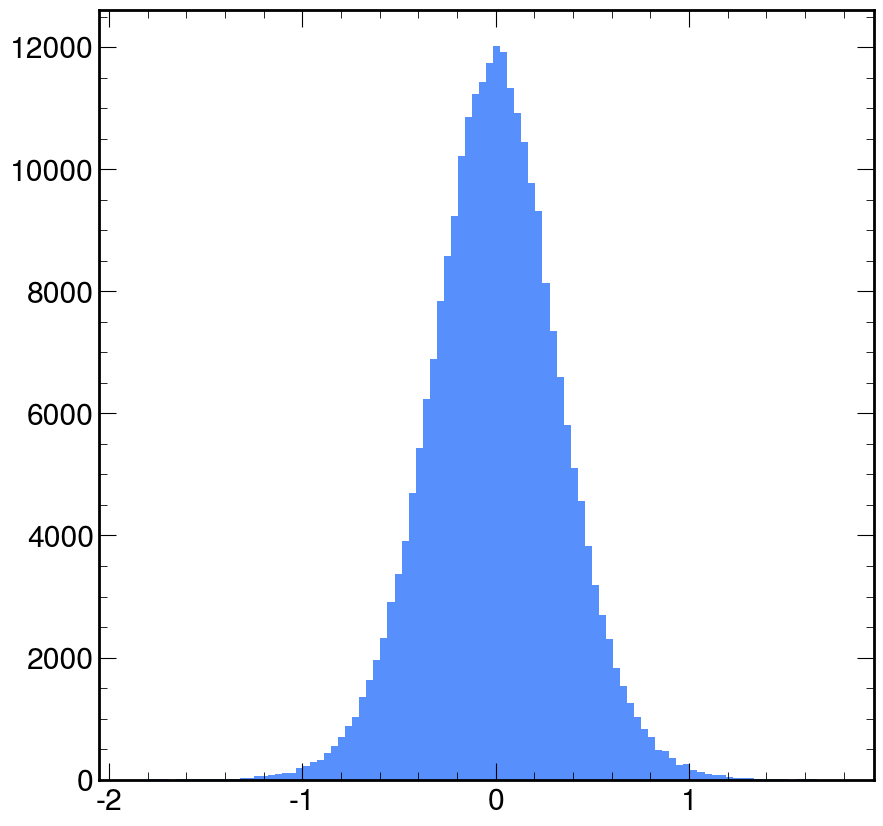

In [99]:
plt.hist((mha_out-li_out).detach().numpy().flatten(), bins=100);

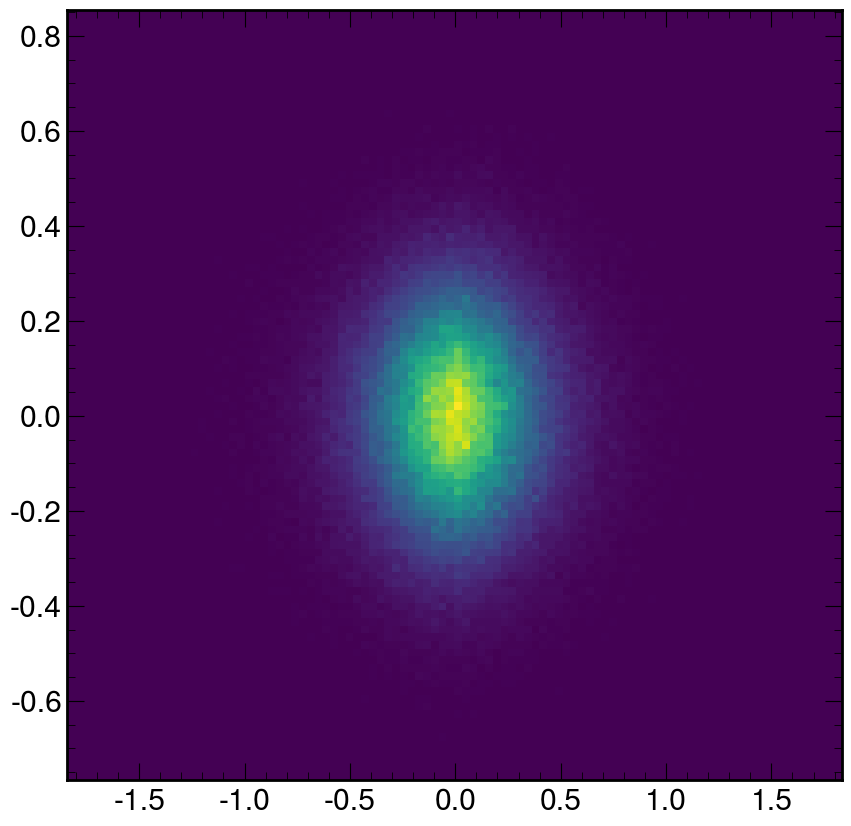

In [100]:
plt.hist2d(mha_out.detach().numpy().flatten(), li_out.detach().numpy().flatten(), bins=100);

In [ ]:
model_simple_fused = copy.deepcopy(model_simple)

#configure the model to run in (batch, seq_len, num_heads*head_dim) 3d-mode.
for conv in model_simple_fused.conv_id + model_simple_fused.conv_reg:
    conv.mha.export_onnx = True

#register our custom op that calls out to the fast MultiHeadAttention implementation
@onnxscript.script(custom_opset)
def SDPA(
    query: TFloat,
    key: TFloat,
    value: TFloat,
) -> TFloat:

    # Unlike pytorch scaled_dot_product_attention,
    # the input here MUST BE (batch, seq_len, num_head*head_dim).
    # Also, for the op to be fast on GPU, it needs to run in float16.
    query = op.Cast(query, to=onnx.TensorProto.FLOAT16)
    key = op.Cast(key, to=onnx.TensorProto.FLOAT16)
    value = op.Cast(value, to=onnx.TensorProto.FLOAT16)
    output, _, _ = msft_op.MultiHeadAttention(query, key, value, num_heads=NUM_HEADS)
    output = op.Cast(output, to=onnx.TensorProto.FLOAT)

    return output


# setType API provides shape/type to ONNX shape/type inference
# function signature must match pytorch aten::scaled_dot_product_attention from
# https://github.com/pytorch/pytorch/blob/16676fd17b10b06e692656bbba8db5e0d6052a20/aten/src/ATen/native/transformers/attention.cpp#L699
def custom_scaled_dot_product_attention(
    g, query: TFloat, key: TFloat, value: TFloat, attn_mask=None, dropout_p=0.0, is_causal=False, scale=None, enable_gqa=False
):
    return g.onnxscript_op(SDPA, query, key, value).setType(query.type())


#the warning 'MultiHeadAttention' is not a known op in 'com.microsoft' is not actually important
print("registering custom op for scaled_dot_product_attention")
torch.onnx.register_custom_op_symbolic(
    symbolic_name="aten::scaled_dot_product_attention",
    symbolic_fn=custom_scaled_dot_product_attention,
    opset_version=opset_version,
)

torch.onnx.export(
    model_simple_fused,
    (dummy_features, dummy_mask),
    "test_fp32_fused.onnx",
    opset_version=opset_version,
    verbose=False,
    input_names=[
        "Xfeat_normed", "mask",
    ],
    output_names=["bid", "id", "momentum", "pu"],
    dynamic_axes={
        "Xfeat_normed": {0: "num_batch", 1: "num_elements"},
        "mask": {0: "num_batch", 1: "num_elements"},
        "bid": {0: "num_batch", 1: "num_elements"},
        "id": {0: "num_batch", 1: "num_elements"},
        "momentum": {0: "num_batch", 1: "num_elements"},
        "pu": {0: "num_batch", 1: "num_elements"},
    },
)

In [ ]:
print("Available ONNX runtime providers:", rt.get_available_providers())
sess_options = rt.SessionOptions()
sess_options.intra_op_num_threads = 32  # need to explicitly set this to get rid of onnxruntime error

sess_options.log_severity_level = 1
sess_options.graph_optimization_level = rt.GraphOptimizationLevel.ORT_ENABLE_EXTENDED

execution_provider = "CPUExecutionProvider"
if torch_device.type == "cuda":
    execution_provider = "CUDAExecutionProvider"

In [ ]:
onnx_sess_unfused = rt.InferenceSession("test_fp32_unfused.onnx", sess_options, providers=[execution_provider])

In [ ]:
onnx_sess_fused = rt.InferenceSession("test_fp32_fused.onnx", sess_options, providers=[execution_provider])

In [ ]:
def diffs_vec(pred_reference, pred_test):
    diffs = [torch.mean(torch.abs(torch.flatten(pred_reference[i]-pred_test[i]))).item() for i in range(len(pred_test))]
    return diffs

#cluster particles to jets, return jet pt
def particles_to_jets(pred, mask):
    jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)
    ypred = unpack_predictions(pred)
    for k, v in ypred.items():
        ypred[k] = v[mask].detach().cpu().contiguous().numpy()
    
    counts = torch.sum(mask, axis=1).cpu().numpy()
    clsid = awkward.unflatten(ypred["cls_id"], counts)
    msk = clsid != 0
    p4 = awkward.unflatten(ypred["p4"], counts)
    
    vec = vector.awk(
        awkward.zip(
            {
                "pt": p4[msk][:, :, 0],
                "eta": p4[msk][:, :, 1],
                "phi": p4[msk][:, :, 2],
                "e": p4[msk][:, :, 3],
            }
        )
    )
    cluster = fastjet.ClusterSequence(vec.to_xyzt(), jetdef)
    jets = cluster.inclusive_jets(min_pt=3)
    return jets

In [ ]:
#loop over the dataset, run the 4 different models, save outputs
builder = tfds.builder(dataset, data_dir=data_dir)
ds = builder.as_data_source(split="train")

max_events = 2
events_per_batch = 1
inds = range(0, max_events, events_per_batch)

jets_mlpf = []
jets_mlpf_simple = []
jets_onnx_unfused = []
jets_onnx_fused = []

model = model.to(torch_device)
model_simple = model_simple.to(torch_device)

preds = []
preds_onnx_fused = []
X_feat_list = []
for ind in tqdm(inds):
    ds_elems = [ds[i] for i in range(ind,ind+events_per_batch)]
    X_features = [torch.tensor(elem["X"]).to(torch.float32).to(torch_device) for elem in ds_elems]
    y_targets = [torch.tensor(elem["ytarget"]).to(torch.float32).to(torch_device) for elem in ds_elems]
    X_feat_list += X_features

    #batch the data into [batch_size, num_elems, num_features]
    X_features_padded = pad_sequence(X_features, batch_first=True).contiguous()
    y_targets_padded = pad_sequence(y_targets, batch_first=True).contiguous()
    # print("batch", ind, X_features_padded.shape)
    mask = X_features_padded[:, :, 0]!=0
    mask_f = mask.float()

    with torch.no_grad():
        # print("running base pytorch model")
        pred = model(X_features_padded.to(torch_device), mask.to(torch_device))
        pred = tuple(pred[x].cpu() for x in range(len(pred)))
        preds.append(pred)
        # print("running simplified pytorch model")
        pred_simple = model_simple(X_features_padded.to(torch_device), mask.to(torch_device))
        pred_simple = tuple(pred_simple[x].cpu() for x in range(len(pred_simple)))

    j0 = particles_to_jets(pred, mask.cpu())
    jets_mlpf.append(j0)
    
    j1 = particles_to_jets(pred_simple, mask.cpu())
    jets_mlpf_simple.append(j1)

    #test that the classification and regression outputs are close between the original and simplified pytorch models
    # diffs = diffs_vec(pred, pred_simple)
    # print("diffs: {:.8f} {:.8f}".format(*diffs))
    #torch.testing.assert_close(pred[0], pred_simple[0], atol=0.01, rtol=0.01)
    #torch.testing.assert_close(pred[1], pred_simple[1], atol=0.01, rtol=0.01)

    # print("running ONNX unfused model")
    pred_onnx_unfused = onnx_sess_unfused.run(["bid", "id", "momentum", "pu"], {"Xfeat_normed": X_features_padded.cpu().numpy(), "mask": mask_f.cpu().numpy()})
    pred_onnx_unfused = tuple(torch.tensor(p) for p in pred_onnx_unfused)
    j2 = particles_to_jets(pred_onnx_unfused, mask.cpu())
    jets_onnx_unfused.append(j2)
    # diffs = diffs_vec(pred_simple, pred_onnx_unfused)
    # print("diffs: {:.8f} {:.8f}".format(*diffs))
    #torch.testing.assert_close(pred_simple[0], pred_onnx_unfused[0], atol=0.01, rtol=0.01)
    #torch.testing.assert_close(pred_simple[1], pred_onnx_unfused[1], atol=0.01, rtol=0.01)
    
    # print("running ONNX fused model")
    pred_onnx_fused = onnx_sess_fused.run(["bid", "id", "momentum", "pu"], {"Xfeat_normed": X_features_padded.cpu().numpy(), "mask": mask_f.cpu().numpy()})
    pred_onnx_fused = tuple(torch.tensor(p) for p in pred_onnx_fused)
    preds_onnx_fused.append(pred_onnx_fused)
    
    j3 = particles_to_jets(pred_onnx_fused, mask.cpu())
    jets_onnx_fused.append(j3)
    # diffs = diffs_vec(pred_onnx_unfused, pred_onnx_fused)
    # print("diffs: {:.8f} {:.8f}".format(*diffs))
    # this does not exactly close on CUDAExecutionProvider
    # torch.testing.assert_close(pred_onnx_unfused[0], pred_onnx_fused[0], atol=0.1, rtol=0.1)
    # torch.testing.assert_close(pred_onnx_unfused[1], pred_onnx_fused[1], atol=0.1, rtol=0.1)

    # print("jets", awkward.count(j0), awkward.count(j1), awkward.count(j2), awkward.count(j3))

    for conv in model.conv_id + model.conv_reg:
        conv.att_mat_idx += 1

In [ ]:
def sum_overflow_into_last_bin(all_values):
    values = all_values[1:-1]
    values[-1] = values[-1] + all_values[-1]
    values[0] = values[0] + all_values[0]
    return values

def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    h1[:] = sum_overflow_into_last_bin(h1.values(flow=True)[:])
    return h1

In [ ]:
#There can be cases where different inference modes produce very slightly different numbers of jets due to floating point differences.
#Therefore, we match jet pairs based on delta-R, and compare the pT of matched jets.
match_inds1, match_inds2 = match_jets(to_p4_sph(awkward.concatenate(jets_mlpf)), to_p4_sph(awkward.concatenate(jets_mlpf_simple)), 0.001)
match_inds3, match_inds4 = match_jets(to_p4_sph(awkward.concatenate(jets_mlpf_simple)), to_p4_sph(awkward.concatenate(jets_onnx_unfused)), 0.001)
match_inds5, match_inds6 = match_jets(to_p4_sph(awkward.concatenate(jets_onnx_unfused)), to_p4_sph(awkward.concatenate(jets_onnx_fused)), 0.001)
match_inds7, match_inds8 = match_jets(to_p4_sph(awkward.concatenate(jets_mlpf)), to_p4_sph(awkward.concatenate(jets_onnx_fused)), 0.001)

In [ ]:
b = np.logspace(0, 2, 200)
plt.figure(figsize=(6,5))
plt.hist2d(
    awkward.to_numpy(awkward.flatten(awkward.concatenate(jets_mlpf)[match_inds1].pt)),
    awkward.to_numpy(awkward.flatten(awkward.concatenate(jets_mlpf_simple)[match_inds2].pt)),
    bins=b,
    norm=mpl.colors.LogNorm(),
    cmap="Reds"
);
plt.xlabel("jet $p_{\mathrm{T,pytorch}}$")
plt.ylabel("jet $p_{\mathrm{T,pytorch,simple}}$")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()

In [ ]:
b = np.logspace(0, 2, 200)
plt.figure(figsize=(6,5))
plt.hist2d(
    awkward.to_numpy(awkward.flatten(awkward.concatenate(jets_mlpf_simple)[match_inds3].pt)),
    awkward.to_numpy(awkward.flatten(awkward.concatenate(jets_onnx_unfused)[match_inds4].pt)),
    bins=b,
    norm=mpl.colors.LogNorm(),
    cmap="Reds"
);
plt.xlabel("jet $p_{\mathrm{T,pytorch,simple}}$")
plt.ylabel("jet $p_{\mathrm{T,ONNX}}$")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()

In [ ]:
b = np.logspace(0, 2, 200)
plt.figure(figsize=(6,5))
plt.hist2d(
    awkward.to_numpy(awkward.flatten(awkward.concatenate(jets_onnx_unfused)[match_inds5].pt)),
    awkward.to_numpy(awkward.flatten(awkward.concatenate(jets_onnx_fused)[match_inds6].pt)),
    bins=b,
    norm=mpl.colors.LogNorm(vmin=1),
    cmap="Reds"
);
plt.xlabel("jet $p_{\mathrm{T,ONNX}}$")
plt.ylabel("jet $p_{\mathrm{T,ONNX,fused}}$")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()

In [ ]:
b = np.logspace(0, 2, 200)
plt.figure(figsize=(12,10))
ax = plt.axes()
plt.hist2d(
    awkward.to_numpy(awkward.flatten(awkward.concatenate(jets_mlpf)[match_inds7].pt)),
    awkward.to_numpy(awkward.flatten(awkward.concatenate(jets_onnx_fused)[match_inds8].pt)),
    bins=b,
    norm=mpl.colors.LogNorm(vmin=1),
    cmap="Reds"
);
plt.xlabel("jet $p_{\mathrm{T,pytorch}}$")
plt.ylabel("jet $p_{\mathrm{T,ONNX}}$")
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
cms_label(ax)
sample_label(ax, "cms_pf_ttbar_nopu")
plt.savefig("pytorch_onnx_jet_pt_2d.pdf", bbox_inches="tight")

In [ ]:
match_inds9, match_inds10 = match_jets(to_p4_sph(awkward.concatenate(jets_mlpf)), to_p4_sph(awkward.concatenate(jets_onnx_fused)), 0.001)

In [ ]:
awkward.count(match_inds9)/awkward.count(awkward.concatenate(jets_mlpf))

In [ ]:
b = np.linspace(0.9,1.1, 500)
plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.hist(
    awkward.flatten(awkward.concatenate(jets_onnx_fused)[match_inds10].pt/awkward.concatenate(jets_mlpf)[match_inds9].pt),
    bins=b, histtype="step");
plt.yscale("log")
plt.xlabel("jet $p_{\mathrm{T,ONNX,fused}}/p_{\mathrm{T,pytorch}}$")
plt.ylabel("Number of matched jets")
cms_label(ax)
sample_label(ax, "cms_pf_ttbar_nopu")
plt.savefig("pytorch_onnx_jet_ratio.pdf")

In [ ]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [4, 1]}, sharex=True, figsize=(10, 10))

plt.sca(a0)

b = np.logspace(0,2,101)
h0 = to_bh(awkward.flatten(awkward.concatenate(jets_mlpf).pt), bins=b)
h1 = to_bh(awkward.flatten(awkward.concatenate(jets_mlpf_simple).pt), bins=b)
h2 = to_bh(awkward.flatten(awkward.concatenate(jets_onnx_unfused).pt), bins=b)
h3 = to_bh(awkward.flatten(awkward.concatenate(jets_onnx_fused).pt), bins=b)

mplhep.histplot(h0, label="pytorch", lw=0.5, yerr=0)
# mplhep.histplot(h1, label="pytorch, simplified", lw=0.5, yerr=0)
# mplhep.histplot(h2, label="ONNX, unfused", lw=0.5, yerr=0)
mplhep.histplot(h3, label="ONNX, fused", lw=0.5, yerr=0)
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.ylabel("Number of jets")
cms_label(a0)
sample_label(a0, "cms_pf_ttbar_nopu")

plt.sca(a1)
mplhep.histplot(h0/h0, label="pytorch", lw=0.5, yerr=0)
# mplhep.histplot(h1/h0, label="pytorch, simplified", lw=0.5, yerr=0)
# mplhep.histplot(h2/h0, label="ONNX, unfused", lw=0.5, yerr=0)
mplhep.histplot(h3/h0, label="ONNX, fused", lw=0.5, yerr=0)
plt.ylim(0.5, 1.5)
plt.xlim(1, 100)
plt.ylabel("vs. pytorch")
plt.xlabel("jet $p_T$ [GeV]")
plt.savefig("pytorch_onnx_jet_pt.pdf")

In [ ]:
plt.figure(figsize=(6,5))
att_mat_reg2 = np.load("attn_conv_reg_2_0.npz")["att"]
plt.imshow(att_mat_reg2[0], cmap="hot_r", norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=1))
plt.colorbar()

In [ ]:
X_etaphi = [X[:, 2:5].numpy() for X in X_feat_list]

In [ ]:
from numba import njit

@njit
def calculate_delta_r(particles):
    """
    Calculates the Delta R matrix for a set of particles.

    Args:
        particles (np.ndarray): An N x 3 matrix where N is the number of particles.
                                Each row contains [eta, sin(phi), cos(phi)].

    Returns:
        np.ndarray: An N x N matrix containing the Delta R values between
                    each pair of particles.
    """
    n_particles = particles.shape[0]
    delta_r_matrix = np.empty((n_particles, n_particles), dtype=np.float64)

    # Calculate phi for all particles first
    phis = np.empty(n_particles, dtype=np.float64)
    for i in range(n_particles):
        phis[i] = np.arctan2(particles[i, 1], particles[i, 2]) # atan2(sin(phi), cos(phi))

    for i in range(n_particles):
        for j in range(n_particles):
            if i == j:
                delta_r_matrix[i, j] = 0.0
                continue

            eta1 = particles[i, 0]
            phi1 = phis[i]

            eta2 = particles[j, 0]
            phi2 = phis[j]

            delta_eta = eta1 - eta2
            
            delta_phi = phi1 - phi2
            delta_phi = np.arctan2(np.sin(delta_phi), np.cos(delta_phi))

            delta_r_matrix[i, j] = np.sqrt(delta_eta**2 + delta_phi**2)
            
    return delta_r_matrix

In [ ]:
dr_mat = calculate_delta_r(X_etaphi[0])

In [ ]:
np.max(dr_mat.flatten())

In [ ]:
plt.hist2d(
    dr_mat.flatten(),
    att_mat_reg2.flatten(),
    bins=(np.linspace(0,10,100), np.logspace(-5,0, 100)),
    cmap="hot_r"
);
plt.yscale("log")

In [ ]:
att_mat_0 = np.load("attn_conv_id_0_0.npz")["att"]
att_mat_1 = np.load("attn_conv_id_1_0.npz")["att"]
att_mat_2 = np.load("attn_conv_id_2_0.npz")["att"]

attention_matrices = [att_mat_0, att_mat_1, att_mat_2]

In [ ]:
titles_att = ["self-attention $A^{cls0}_{ij}$", "self-attention $A^{cls1}_{ij}$", "self-attention $A^{cls2}_{ij}$"]
titles_corr = ["", "", ""]

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10), constrained_layout=True, gridspec_kw={'height_ratios': [1, 1]})

# Plotting parameters
imshow_norm = matplotlib.colors.LogNorm(vmin=1e-6, vmax=1)
hist2d_bins = (np.logspace(-2, 2, 100), np.logspace(-6, 0, 100))
cmap_choice = "hot_r"

# Top row: Attention Matrices
for i, att_mat in enumerate(attention_matrices):
    ax = axes[0, i]
    im = ax.imshow(att_mat[0], cmap=cmap_choice, norm=imshow_norm)
    fig.colorbar(im, ax=ax) # Let constrained_layout handle colorbar spacing
    ax.set_title(titles_att[i])
    ax.set_xlabel("elem. i")
    ax.set_ylabel("elem. j")


# Bottom row: DR-Attention Correlations
for i, att_mat in enumerate(attention_matrices):
    ax = axes[1, i]
    
    counts, xedges, yedges, im = ax.hist2d(
        dr_mat.flatten(),
        att_mat.flatten(),
        bins=hist2d_bins,
        cmap=cmap_choice,
        norm=matplotlib.colors.LogNorm(vmin=1, vmax=1e6)
    )
    fig.colorbar(im, ax=ax) # Let constrained_layout handle colorbar spacing
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title(titles_corr[i])
    ax.set_xlabel("$\Delta R_{ij}$")
    ax.set_ylabel("attn. score $A_{ij}$")
    ax.set_box_aspect(1)
plt.savefig("attention_scores.pdf", bbox_inches="tight")
plt.show()